<a href="https://colab.research.google.com/github/bismillahkani/ISL-CV-Team3/blob/master/ISL_Deep_Learning_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing data

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/ISL/ISL-image-dataset-7k.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

Import libraries

In [4]:
import numpy as np
import pandas as pd
import glob
import cv2
import math    
from PIL import Image
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Using TensorFlow backend.


Visualize data

In [0]:
dataset_path = '/tmp/ISL-image-dataset-7k/training/'
image_paths=[image_path for image_path in glob.glob(dataset_path+'/*/*.jpg')]
image_categories=[os.path.basename(os.path.dirname(image_path)) for image_path in image_paths]
filenames=[os.path.basename(image_path) for image_path in image_paths]

In [6]:
dataset_df = pd.DataFrame({'image_paths':image_paths,'filename':filenames,'image_category':image_categories})
dataset_df.sort_values('image_category',inplace=True)
dataset_df

,image_paths,filename,image_category
7103,/tmp/ISL-image-dataset-7k/training/1/21 25_res...,21 25_result.jpg,1
6973,/tmp/ISL-image-dataset-7k/training/1/1 05_resu...,1 05_result.jpg,1
6972,/tmp/ISL-image-dataset-7k/training/1/1 49_resu...,1 49_result.jpg,1
6971,/tmp/ISL-image-dataset-7k/training/1/11 35_res...,11 35_result.jpg,1
6970,/tmp/ISL-image-dataset-7k/training/1/11 08_res...,11 08_result.jpg,1
...,...,...,...
110,/tmp/ISL-image-dataset-7k/training/Z/Z3 12_res...,Z3 12_result.jpg,Z
109,/tmp/ISL-image-dataset-7k/training/Z/Z3 15_res...,Z3 15_result.jpg,Z
108,/tmp/ISL-image-dataset-7k/training/Z/Z3 35_res...,Z3 35_result.jpg,Z
116,/tmp/ISL-image-dataset-7k/training/Z/Z4 08_res...,Z4 08_result.jpg,Z


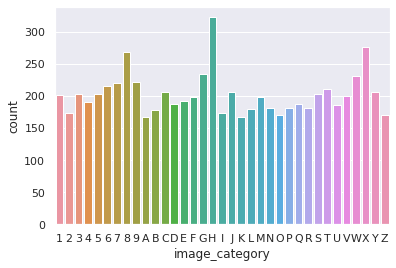

In [7]:
sns.set(style="darkgrid")
ax = sns.countplot(x="image_category", data=dataset_df)

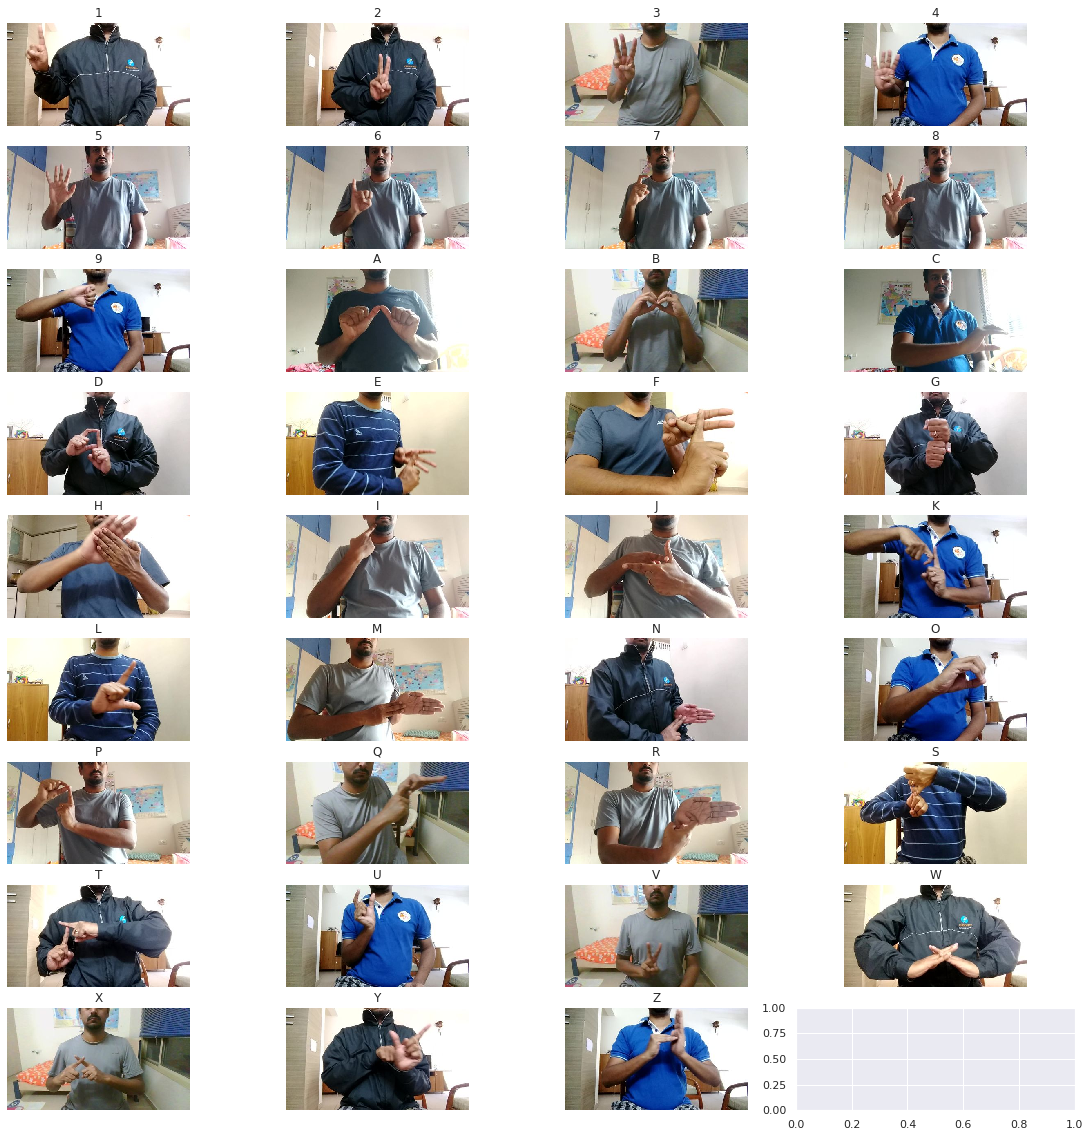

In [8]:
def plot_grid_of_images(image_paths, labels, figsize=(20, 20), no_columns=5):
    images = [cv2.imread(image_path) for image_path in image_paths]    
    images = [cv2.cvtColor(image, cv2.COLOR_RGB2BGR) for image in images]
    fig,a =  plt.subplots(math.ceil(len(image_paths)/no_columns),no_columns,figsize=figsize)

    for i, (image, label) in enumerate(zip(images, labels)):
      a[int(i/no_columns)][i%no_columns].imshow(image,cmap = cm.Greys_r)
      a[int(i/no_columns)][i%no_columns].set_title(label)   
      a[int(i/no_columns)][i%no_columns].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

sample_image_paths=[list(dataset_df['image_paths'][dataset_df['image_category']==char])[0] for char in sorted(set(dataset_df['image_category']))]
plot_grid_of_images(sample_image_paths,labels=sorted(set(dataset_df['image_category'])),no_columns=4)

In [18]:
img = cv2.imread('/tmp/ISL-image-dataset-7k/training/1/1 01_result.jpg')
img.shape

(252, 448, 3)

Helper functions

In [0]:
# Helper function to plot learning curves

def plot_training(history):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(history.history["val_loss"], label="val_loss")
    ax.plot(history.history["loss"], label="train_loss")
    ax.set_title("validation/training loss")
    ax.set_xlabel("epochs")
    ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(history.history["val_acc"], label="val_acc")
    ax2.plot(history.history["acc"], label="train_acc")
    ax2.set_title("validation/training accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0, 1)
    ax2.legend()

    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Image Generator

In [10]:
data_dir = '/tmp/ISL-image-dataset-7k/training/'
#data_dir = '/content/drive/My Drive/ISL/train/'
target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB
n_classes = 35
#n_classes = 24
val_frac = 0.1
batch_size = 32

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True,
                                    # rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range = 0.2,
                                    # horizontal_flip=True,
                                    fill_mode='nearest',                                    
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=False,subset="validation")



Found 6408 images belonging to 35 classes.
Found 696 images belonging to 35 classes.


Model callbacks

In [0]:
def scheduler(epoch):
  if epoch < 3:
    return 0.001
  else:
    return 0.001 * 1/(1 + 0.0001 * epoch)

learning_rate_scheduler = LearningRateScheduler(scheduler)

earlystopping = EarlyStopping(monitor='acc', mode='max', patience=5, verbose=1)

checkpoint = ModelCheckpoint('/content/drive/My Drive/ISL/isl_v1.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

callbacks = [learning_rate_scheduler, earlystopping, checkpoint]

Model 1 - CNN

In [26]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=target_dims))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

sgd = optimizers.SGD(lr=0.0001)
adam = optimizers.Adam(lr=0.001)

#model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 100, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)        

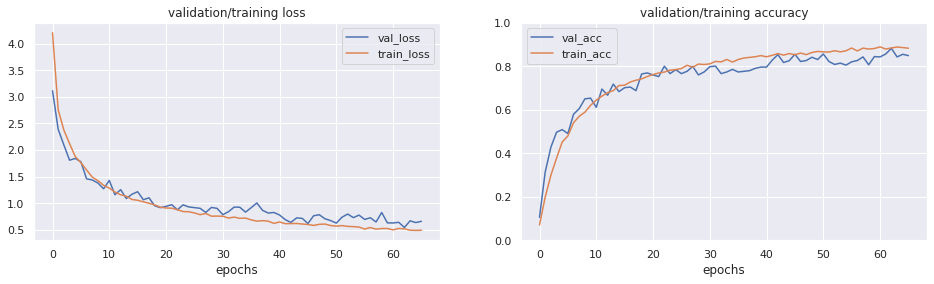

In [27]:
plot_training(history)

Model 1 - CNN Improvements

1. Maxpooling after 2 conv layers
2. Dropout of 0.25 between two dense layers
3. Learning rate scheduler
4. Early stopping
5. Data augmentation
6. Batch normalization

In [28]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=target_dims))
# model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

# sgd = optimizers.SGD(momentum=0.9)
adam = optimizers.Adam(lr=0.001)

# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 100, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 21632)            

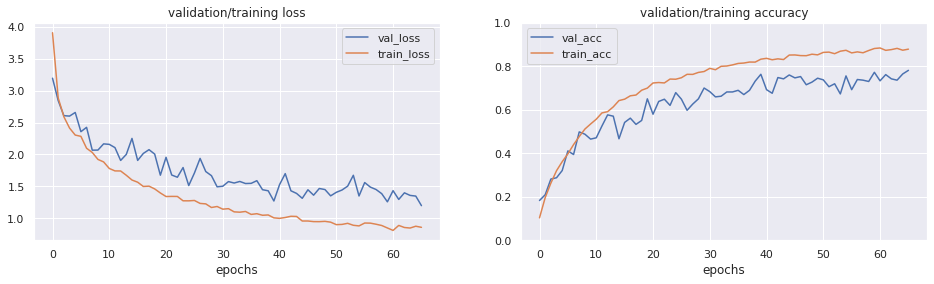

In [29]:
plot_training(history)

pre-trained VGG 16

In [19]:
from keras.applications.vgg16 import preprocess_input

data_dir = '/tmp/ISL-image-dataset-7k/training/'
val_frac = 0.1
batch_size = 32
n_classes = 35
target_size = (224, 224)
target_dims = (224, 224, 3)
color_mode='rgb'

data_augmentor = ImageDataGenerator(
      # rescale=1./255,
      # rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      # # horizontal_flip=True,
      fill_mode='nearest',  
      preprocessing_function=preprocess_input,
      validation_split=val_frac)


train_generator = data_augmentor.flow_from_directory(data_dir,
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     color_mode=color_mode,
                                                     subset="training")

val_generator = data_augmentor.flow_from_directory(data_dir,
                                                          target_size=target_size,
                                                          batch_size=batch_size,
                                                          shuffle = False,
                                                          color_mode=color_mode,
                                                          subset="validation")

Found 6408 images belonging to 35 classes.
Found 696 images belonging to 35 classes.


In [21]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=target_dims)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

# Freezing the Conv layers from VGG16
for layer in base_model.layers:
  layer.trainable = False
  # print(layer.name,layer.trainable)

model.summary()

# sgd = optimizers.SGD(momentum=0.9)
adam = optimizers.Adam()

# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 100, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 35)                878115    
Total params: 15,592,803
Trainable params: 878,115
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 120s 600ms/step - loss: 14.6989 - acc: 0.0845 - val_loss: 14.0205 - val_acc: 0.1265
Epoch 2/100
200/200 [==============================] - 110s 551ms/step - loss: 14.4964 - acc: 0.0984 - val_loss: 14.2258 - val_acc: 0.1160
Epoch 3/100
200/200 [==============================] - 110s 548ms/step - loss: 14.2168 -

KeyboardInterrupt: ignored

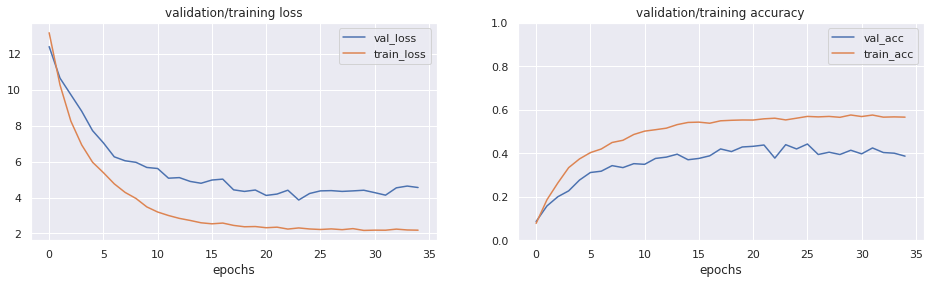

In [32]:
plot_training(history)

Train only last layer for few epochs then unfreeze all layers and train

In [42]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=target_dims)
base_model.trainable = False

# Freezing the Conv layers from VGG16
for layer in base_model.layers:
  layer.trainable = False
  # print(layer.name,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

# sgd = optimizers.SGD(momentum=0.9)
adam = optimizers.Adam(lr=0.001)

# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 10, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

# UnFreezing all layers
for layer in base_model.layers:
  layer.trainable = True
  # print(layer.name,layer.trainable)



sgd = optimizers.SGD(lr=0.001, momentum=0.9)
# adam = optimizers.Adam(lr=0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

model.summary()

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 100, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

input_9 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 35)                71715     
Total params: 14,786,403
Trainable params: 71,715
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
200/

pre-trained InceptionV3

In [46]:
data_dir = '/tmp/ISL-image-dataset-7k/training/'
val_frac = 0.1
batch_size = 32
n_classes = 35
target_size = (299, 299)
target_dims = (299, 299, 3)
color_mode='rgb'

data_augmentor = ImageDataGenerator(
      # rescale=1./255,
      # rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      # # horizontal_flip=True,
      fill_mode='nearest',  
      # preprocessing_function=preprocess_input,
      validation_split=val_frac)


train_generator = data_augmentor.flow_from_directory(data_dir,
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     color_mode=color_mode,
                                                     subset="training")

val_generator = data_augmentor.flow_from_directory(data_dir,
                                                          target_size=target_size,
                                                          batch_size=batch_size,
                                                          shuffle = False,
                                                          color_mode=color_mode,
                                                          subset="validation")



# data_dir = "/tmp/asl_alphabet_train/asl_alphabet_train"
# target_size = (150, 150)
# target_dims = (150, 150, 3) # add channel for RGB
# n_classes = 29
# val_frac = 0.2
# batch_size = 20

# data_augmentor = ImageDataGenerator(samplewise_center=True, 
#                                     samplewise_std_normalization=True, 
#                                     validation_split=val_frac)

# train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
# val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 6408 images belonging to 35 classes.
Found 696 images belonging to 35 classes.


In [0]:
base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=target_dims)
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

for layer in base_model.layers:
  layer.trainable = False
  # print(layer.name,layer.trainable)

model.summary()

# sgd = optimizers.SGD(momentum=0.9)
adam = optimizers.Adam(lr=0.001)

# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 100, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)



87916544/87910968 [==============================] - 3s 0us/step
input_10 False
conv2d_17 False
batch_normalization_1 False
activation_1 False
conv2d_18 False
batch_normalization_2 False
activation_2 False
conv2d_19 False
batch_normalization_3 False
activation_3 False
max_pooling2d_15 False
conv2d_20 False
batch_normalization_4 False
activation_4 False
conv2d_21 False
batch_normalization_5 False
activation_5 False
max_pooling2d_16 False
conv2d_25 False
batch_normalization_9 False
activation_9 False
conv2d_23 False
conv2d_26 False
batch_normalization_7 False
batch_normalization_10 False
activation_7 False
activation_10 False
average_pooling2d_1 False
conv2d_22 False
conv2d_24 False
conv2d_27 False
conv2d_28 False
batch_normalization_6 False
batch_normalization_8 False
batch_normalization_11 False
batch_normalization_12 False
activation_6 False
activation_8 False
activation_11 False
activation_12 False
mixed0 False
conv2d_32 False
batch_normalization_16 False
activation_16 False
conv2d

In [0]:
plot_training(history)

pre-trained ResNet

In [12]:
from keras.applications.resnet import preprocess_input

data_dir = "/tmp/ISL-image-dataset-7k/training"
val_frac = 0.1
batch_size = 32
n_classes = 35
target_size = (224, 224)
target_dims = (224, 224, 3)
color_mode='rgb'

data_augmentor = ImageDataGenerator(
      # rescale=1./255,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      # horizontal_flip=True,
      fill_mode='nearest',  
      preprocessing_function=preprocess_input,
      validation_split=val_frac)


train_generator = data_augmentor.flow_from_directory(data_dir,
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     color_mode=color_mode,
                                                     subset="training")

val_generator = data_augmentor.flow_from_directory(data_dir,
                                                          target_size=target_size,
                                                          batch_size=batch_size,
                                                          shuffle=True,
                                                          color_mode=color_mode,
                                                          subset="validation")

Found 6408 images belonging to 35 classes.
Found 696 images belonging to 35 classes.


In [15]:
from keras.applications.resnet import ResNet50

base_model = ResNet50(weights = 'imagenet', include_top=False, input_shape=target_dims)
base_model.trainable = False

model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.7))
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Freezing the Conv layers from VGG16
for layer in base_model.layers:
  layer.trainable = False
  # print(layer.name,layer.trainable)

model.summary()

# sgd = optimizers.SGD(momentum=0.9)
adam = optimizers.Adam(lr=0.001)

# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.samples // train_generator.batch_size), 
                              epochs = 100, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.samples // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 35)                286755    
Total params: 23,874,467
Trainable params: 286,755
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 38s 188ms/step - loss: 3.5525 - acc: 0.2820 - val_loss: 9.8264 - val_acc: 0.1205
Epoch 2/100
200/200 [==============================] - 28s 142ms/step - loss: 2.7265 - acc: 0.4223 - val_loss: 10.9989 - val_acc: 0.0994
Epoch 3/100
200/200 [==============================] - 29s 146ms/step - loss: 2.5374 - acc: 0

KeyboardInterrupt: ignored

In [0]:
plot_training(history)

Predicting test data

In [0]:
import numpy as np
from keras.preprocessing import image

test_path = '/tmp/asl_alphabet_test/asl_alphabet_test'
files = os.listdir(test_path)

for file in files:
  full_file = os.path.join(test_path,file)
  img = image.load_img(full_file, target_size=image_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(file)
  print(classes)

Z_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0.]]
space_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1.]]
U_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0.]]
X_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0.]]
A_test.jpg
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
V_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0.]]
H_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
M_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
B_test.jpg
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
Q_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=image_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving O_test.jpg to O_test.jpg
O_test.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
